In [1]:
import findspark
findspark.init()

import pyspark
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

In [35]:

import matplotlib.pyplot as pyplt
import numpy as np
from ggplot import *
from datetime import datetime

import pyspark.sql.functions as sf


<h4> Helper functions </h4>

In [3]:
def getInt(x):
    try: v = int(x)
    except: v = 0
    return v


def getDate(x):
    try: v = datetime.strptime(x,"%Y%m%d").date()
    except: v = datetime.strptime("19010101","%Y%m%d").date()
    return v

def nothing(x):
    return x

def getFloat(x):
    try: v = float(x)
    except: v = 0
    return v


# Rename columns of a dataframe using the array of new names
def renameCols(df,newNames):
    nDF = df
    assert(len(df.schema.names) == len(newNames))
    for i in range(0,len(df.schema.names)):
        nDF = nDF.withColumnRenamed(nDF.schema.names[i],newNames[i])
    return nDF

# Takes a list of functions, and applies thme to the row, 
# input: array of strings
# output: tuple ( types as determinted by the return type of the functions )
def getTupleFromSchema(l,colExtractors):
   assert(len(colExtractors) == len(l))
   return tuple ( [colExtractors[i](l[i]) for i in range(0,len(l))] )


In [4]:
def getDF(fname,colExtractors):
   # read the file
   inRDD = sc.textFile(fname)

    # get the schema from the first row
   schema = ''.join(inRDD.take(1)).split(',')
    
   # leave out the first row (assumed column)
   allRowsExceptFirst = inRDD.zipWithIndex().filter(lambda r: r[1] > 0 ).map(lambda r: r[0])
   
   # create the RDD of interest, mapping the colums as we go. 
   tRDD = allRowsExceptFirst.map(lambda l: l.replace(' ','').split(','))\
              .map(lambda l: getTupleFromSchema(l, colExtractors))
    
    # Rename columns based on schema
   tDF = renameCols(tRDD.toDF(),schema)
   return tDF

<h1> Real Program Starts Here </h1>

<h5> Get a clean memDF ("DF of members") </h5>

In [5]:
memDF = getDF('dataset/members.csv',[nothing,getInt,getInt,nothing,getInt,getDate,getDate])
memDF.show(5)

+--------------------+----+---+------+--------------+----------------------+---------------+
|                msno|city| bd|gender|registered_via|registration_init_time|expiration_date|
+--------------------+----+---+------+--------------+----------------------+---------------+
|URiXrfYPzHAlk+7+n...|   1|  0|      |             9|            2015-05-25|     2015-05-26|
|U1q0qCqK/lDMTD2kN...|   1|  0|      |             4|            2016-12-21|     2016-12-24|
|W6M2H2kAoN9ahfDYK...|   1|  0|      |             4|            2016-03-06|     2016-03-09|
|1qE5+cN7CUyC+KFH6...|   5| 17|female|             4|            2016-10-31|     2016-11-07|
|SeAnaZPI+tFdAt+r3...|   1|  0|      |             4|            2017-02-02|     2017-02-05|
+--------------------+----+---+------+--------------+----------------------+---------------+
only showing top 5 rows



<h5> Get a clean sampleSubZeroDF ("DF of Sample Submission") </h5>

In [6]:
sampleSubZeroDF = getDF('dataset/sample_submission_zero.csv',[nothing,getInt])
sampleSubZeroDF.show(5)

+--------------------+--------+
|                msno|is_churn|
+--------------------+--------+
|ugx0CjOMzazClkFzU...|       0|
|f/NmvEzHfhINFEYZT...|       0|
|zLo9f73nGGT1p21lt...|       0|
|8iF/+8HY8lJKFrTc7...|       0|
|K6fja4+jmoZ5xG6By...|       0|
+--------------------+--------+
only showing top 5 rows



<h5> Get a clean trainDF ("DF of train") </h5>

In [7]:
trainDF = getDF('dataset/train.csv',[nothing,getInt])
trainDF.show(5)

+--------------------+--------+
|                msno|is_churn|
+--------------------+--------+
|waLDQMmcOu2jLDaV1...|       1|
|QA7uiXy8vIbUSPOkC...|       1|
|fGwBva6hikQmTJzrb...|       1|
|mT5V8rEpa+8wuqi6x...|       1|
|XaPhtGLk/5UvvOYHc...|       1|
+--------------------+--------+
only showing top 5 rows



<h5> Get a clean transactionsDF ("DF of transactions") </h5>

In [8]:
transactionsDF = getDF('dataset/transactions.csv',[nothing,getInt,getInt,getInt,getInt,getInt,getDate,getDate,getInt])
transactionsDF.show(3)

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|YyO+tlZtAXYXoZhNr...|               41|               30|            129|               129|            1|      2015-09-30|            2015-11-01|        0|
|AZtu6Wl0gPojrEQYB...|               41|               30|            149|               149|            1|      2015-09-30|            2015-10-31|        0|
|UkDFI97Qb6+s2LWci...|               41|               30|            129|               129|            1|      2015-09-30|            2016-04-27|        0|
+--------------------+-----------------+------------

In [9]:
userLogDF = getDF('dataset/user_logs_part.csv',[nothing,getDate,getInt,getInt,getInt,getInt,getInt,getInt,getFloat])
userLogDF.show(3)

+--------------------+----------+------+------+------+-------+-------+-------+----------+
|                msno|      date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+----------+------+------+------+-------+-------+-------+----------+
|rxIP2f2aN0rYNp+to...|2015-05-13|     0|     0|     0|      0|      1|      1|   280.335|
|rxIP2f2aN0rYNp+to...|2015-07-09|     9|     1|     0|      0|      7|     11|  1658.948|
|yxiEWwE9VR5utpUec...|2015-01-05|     3|     3|     0|      0|     68|     36| 17364.956|
+--------------------+----------+------+------+------+-------+-------+-------+----------+
only showing top 3 rows



<h3> Lets understand each of the data sets </h3>

<h4> Lets start with members </h4>

In [10]:
memDF.describe().show()

+-------+--------------------+------------------+------------------+-------+------------------+
|summary|                msno|              city|                bd| gender|    registered_via|
+-------+--------------------+------------------+------------------+-------+------------------+
|  count|             5116194|           5116194|           5116194|5116194|           5116194|
|   mean|                null|4.0197252097946246| 9.772362228641056|   null| 5.248127221133522|
| stddev|                null| 5.590288544399844|17.958749250419533|   null|2.2602259031188727|
|    min|+++4vcS9aMH7KWdfh...|                 1|             -6998|       |                 3|
|    max|zzzyOgMk9MljCerbC...|                22|              2015|   male|                16|
+-------+--------------------+------------------+------------------+-------+------------------+



In [11]:
# lets create a 5% sample and evaulate it
memDFsamp = memDF.sample(True,0.05)

In [12]:
memDFsamp.freqItems(['city','bd','gender','registered_via'],0.2).show()

+-----------------+-------------------+----------------+------------------------+
|   city_freqItems|       bd_freqItems|gender_freqItems|registered_via_freqItems|
+-----------------+-------------------+----------------+------------------------+
|[5, 13, 22, 4, 1]|[23, 29, 19, 21, 0]|[male, , female]|        [13, 4, 7, 3, 9]|
+-----------------+-------------------+----------------+------------------------+



In [13]:
for i in ['gender']:
    print (memDFsamp.select(memDFsamp[i]).distinct().show())

+------+
|gender|
+------+
|female|
|  male|
|      |
+------+

None


<h5> We find </h5>
<ul> 
  <li> 22 possible Cities. Most of them are one of 5 (5,22,4,13,1)
  <li> bd (age), seems to have a wide spread from -69988 to 2015
  <li> gender has blank fields
</ul>  

<h4> Lets look at transactions </h4>

In [14]:
transactionsDF.describe().show()

+-------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|                msno| payment_method_id| payment_plan_days|   plan_list_price|actual_amount_paid|     is_auto_renew|          is_cancel|
+-------+--------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|            21547746|          21547746|          21547746|          21547746|          21547746|          21547746|           21547746|
|   mean|                null|38.933103026181946| 31.33906284211815|139.88501507303826|141.98732048354384|0.8519661406812573|0.03976522648819046|
| stddev|                null|3.5079363754412363|30.356493755193444| 130.9647002917678|132.48242402576452|0.3551335546903191|0.19540715192284036|
|    min|+++FOrTS7ab3tIgIh...|                 1|                 0|                 0|                 0|                 0

In [15]:
transactionsDFsamp = transactionsDF.sample(True,0.05)
transactionsDFsamp.freqItems(['payment_plan_days','plan_list_price','actual_amount_paid'],0.2).show()

+---------------------------+-------------------------+----------------------------+
|payment_plan_days_freqItems|plan_list_price_freqItems|actual_amount_paid_freqItems|
+---------------------------+-------------------------+----------------------------+
|             [31, 7, 30, 0]|     [149, 180, 129, 9...|        [149, 180, 129, 9...|
+---------------------------+-------------------------+----------------------------+



<h5> We find </h5>
<ul> 
  <li> Transaction data seems relatively clean
  <li> All values seem within bounds
</ul>  

<h4> Lets look at user logs </h4>

In [16]:
userLogDF.describe().show()

+-------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+
|summary|                msno|            num_25|            num_50|            num_75|           num_985|           num_100|           num_unq|          total_secs|
+-------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+
|  count|               99999|             99999|             99999|             99999|             99999|             99999|             99999|               99999|
|   mean|                null| 6.446634466344664|1.6337163371633716| 1.008090080900809| 1.142011420114201|30.731637316373163|30.049430494304943|-1.84469284615286...|
| stddev|                null|13.699597922127568| 4.203304768321667|2.0173413059183654|2.8517478162596546|  41.3927221784122| 33.84094902403416|1.304264379235331...|
|   

In [17]:
userLogDF.show(10)

+--------------------+----------+------+------+------+-------+-------+-------+----------+
|                msno|      date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+----------+------+------+------+-------+-------+-------+----------+
|rxIP2f2aN0rYNp+to...|2015-05-13|     0|     0|     0|      0|      1|      1|   280.335|
|rxIP2f2aN0rYNp+to...|2015-07-09|     9|     1|     0|      0|      7|     11|  1658.948|
|yxiEWwE9VR5utpUec...|2015-01-05|     3|     3|     0|      0|     68|     36| 17364.956|
|yxiEWwE9VR5utpUec...|2015-03-06|     1|     0|     1|      1|     97|     27| 24667.317|
|yxiEWwE9VR5utpUec...|2015-05-01|     3|     0|     0|      0|     38|     38|  9649.029|
|yxiEWwE9VR5utpUec...|2015-07-02|     4|     0|     1|      1|     33|     10|  10021.52|
|yxiEWwE9VR5utpUec...|2015-08-30|     3|     1|     0|      0|      4|      7|  1119.555|
|yxiEWwE9VR5utpUec...|2015-11-07|     1|     0|     0|      0|      4|      5|   938.022|
|yxiEWwE9V

<h5> We find </h5>
<ul> 
  <li> User logs data seems relatively clean
  <li> Looks like a sparse matrix
  <li> The 100% played column has better mean and std deviation
  <li> There seem to be some major min & max values
</ul>  

<h4> Lets plot some training data </h4>

In [18]:
d = trainDF.groupby(['is_churn']).count()
d.show()

+--------+------+
|is_churn| count|
+--------+------+
|       0|929460|
|       1| 63471|
+--------+------+



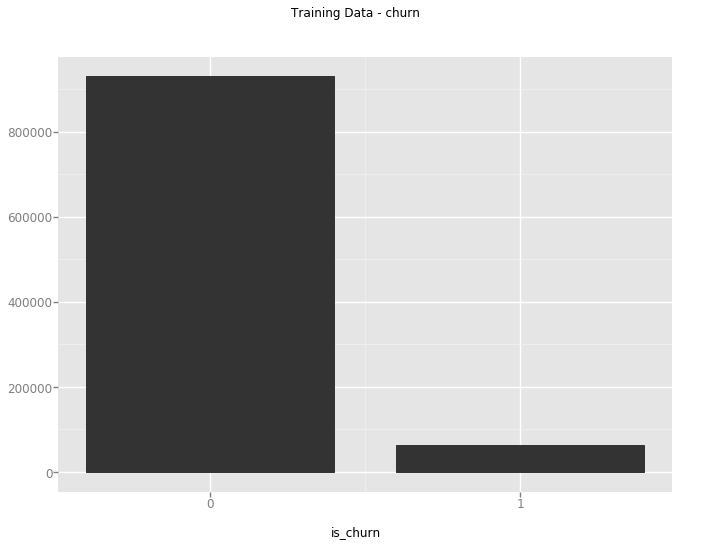

<ggplot: (-9223372036572573205)>

In [19]:
ggplot(aes(x='is_churn'),data=trainDF.toPandas()) + geom_bar() + ggtitle("Training Data - churn")

In [23]:
d = memDF.groupby(['gender']).count()
d.show()

+------+-------+
|gender|  count|
+------+-------+
|female| 858565|
|  male| 902851|
|      |3354778|
+------+-------+



In [ ]:
pyplot.plot(d.select('gender').collect(),d.select('count').collect())

In [27]:
genderData = d.select('gender').collect()

In [28]:
countData = d.select('count').collect()

In [47]:
type(genderData[0])

pyspark.sql.types.Row

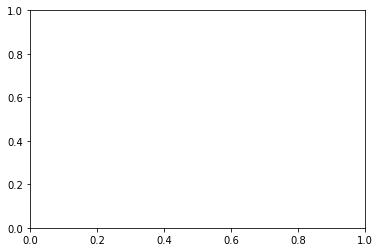

In [44]:
pyplt.figure(1, figsize=(9, 3))
#pyplt.bar(genderData,countData)
pyplt.show()